<a href="https://colab.research.google.com/github/Skander28/Models/blob/main/test(lr).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.  

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
    
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Fri May 19 13:50:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [37]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
fi_df = pd.read_csv('/content/drive/MyDrive/arabic_dialects_clean.csv')
fi_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-37-fbdd277b98d0>:5: DtypeWarning: Columns (0,1,2,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  fi_df = pd.read_csv('/content/drive/MyDrive/arabic_dialects_clean.csv')


,id,dialect,text,word_count,char_count,avg_char_per_word,stopwords,emoji_count,clean_text
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,8.0,48.0,5.125000,1,0.0,لكن بالنهايه ينتفض يغير
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,19.0,120.0,5.368421,3,0.0,يعني هذا محسوب علي البشر حيونه ووحشيه وتطلبون ...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي,5.0,31.0,5.400000,1,0.0,مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,5.0,42.0,7.600000,0,1.0,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,8.0,34.0,3.857143,1,2.0,وين هل الغيبه اخ محمد


In [39]:
tweets_mag = fi_df[fi_df['dialect'].isin(['TN','DZ','MA','LY'])]
tweets_mag.head()

,id,dialect,text,word_count,char_count,avg_char_per_word,stopwords,emoji_count,clean_text
15482,1009754958479151232,LY,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,19.0,114.0,5.052632,3,0.0,قليلين ادب ومنافقين لو اختهم او قريبتهم تتعاكس...
15483,1009794751548313600,LY,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,10.0,72.0,5.636364,1,2.0,الليبيين متقلبين بس بالنسبه ليا انا ميليشياوي ...
15484,1019989115490787200,LY,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,38.0,234.0,4.875000,6,0.0,كل تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ ا...
15485,1035479791758135168,LY,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,54.0,296.0,4.500000,9,0.0,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل...
15486,1035481122921164800,LY,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,20.0,114.0,4.750000,3,0.0,شكلك متعقده علشان الراجل لي تحبيه ازوج بنت يتي...


In [40]:
# a class representing the dataset
class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [41]:
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTModelDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
  
    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
    
      encoded_review = self.tokenizer.encode_plus(
      text,
      max_length= self.max_len,
      add_special_tokens= True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt'
    )
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)

      return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

In [64]:
from sklearn.model_selection import train_test_split
Extra_Len = 6 # an extra padding in length , found to be useful for increasing F-score
Max_Len = tweets_mag["clean_text"].str.split().str.len().max() + Extra_Len

print(Max_Len)

#Spliting the Training data
Test_Size = 0.05
Rand_Seed = 42 

# Split original data into train and test sets
train_set, test_set = train_test_split(tweets_mag, test_size=Test_Size, random_state=Rand_Seed + 1)

# Split training data into train and validation sets
train_set, evaluation_set = train_test_split(train_set, test_size=Test_Size, random_state=Rand_Seed)

print("Train set: ")
print(train_set["dialect"].value_counts())
print("---------------------------")
print ("test set: ")
print (test_set["dialect"].value_counts())


92.0
Train set: 
MA    269858
TN    138431
LY     32851
DZ     14591
Name: dialect, dtype: int64
---------------------------
test set: 
MA    14933
TN     7683
LY     1819
DZ      814
Name: dialect, dtype: int64


In [65]:
import seaborn as sns

Model_Used = "Davlan/xlm-roberta-base-finetuned-arabic"
Task_Name = "classification"

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map))

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids, preds))
    print(confusion_matrix(p.label_ids, preds))

    test_confusion_matrix = confusion_matrix(p.label_ids, preds, labels=[0, 1, 2, 3])
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(['MA', 'DZ', 'TN', 'LY'], fontsize=12)
    ax.set_yticklabels(['MA', 'DZ', 'TN', 'LY'], fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    macro_f1_pos_neg = f1_score(p.label_ids, preds, average='macro', labels=[1, 2])
    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    macro_precision = precision_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')
    acc = accuracy_score(p.label_ids, preds)

    num_classes = len(np.unique(p.label_ids))

#     if num_classes == 2:
#         # Binary classification case
#         label_pos = np.where(np.unique(p.label_ids) == 1)[0][0]
#         probabilities = p.predictions[:, label_pos]  # Use the probability of the positive class
#         fpr, tpr, _ = roc_curve(p.label_ids, probabilities)
#         roc_auc = auc(fpr, tpr)

#         plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver Operating Characteristic')
#         plt.legend(loc='lower right')
#         plt.show()

#         return {
#             'macro_f1': macro_f1,
#             'macro_f1_pos_neg': macro_f1_pos_neg,
#             'macro_precision': macro_precision,
#             'macro_recall': macro_recall,
#             'accuracy': acc,
#             'roc_auc': roc_auc,
#             'roc_curve': (fpr, tpr),
#         }
#     else:
        # Multiclass classification case
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_label in range(num_classes):
        probabilities = p.predictions[:, class_label]
        fpr[class_label], tpr[class_label], _ = roc_curve(
            p.label_ids, probabilities, pos_label=class_label
        )
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

    for class_label in range(num_classes):
        plt.plot(fpr[class_label], tpr[class_label],
                 label='ROC curve of class %d (area = %0.2f)' % (class_label, roc_auc[class_label]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    print(roc_auc)
    return {
        'macro_f1': macro_f1,
        'macro_f1_pos_neg': macro_f1_pos_neg,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': acc,
        'roc_auc': roc_auc,
        'roc_curve': (fpr, tpr),
    }


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [66]:
# install needed libraries
!pip install pyarabic
!pip install emoji
!pip install pystemmer
!pip install optuna==2.3.0
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Found existing installation: accelerate 0.19.0
Uninstalling accelerate-0.19.0:
  Successfully uninstalled accelerate-0.19.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [67]:
# import needed libraries
import numpy as np
import pandas as pd
import pyarabic.araby as ar
import matplotlib.pyplot as plt

import re , emoji, Stemmer, functools, operator, string
import torch , optuna, gc, random, os

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score, roc_curve, auc
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample

label_list = list(train_set["dialect"].unique())
print(label_list)
print(train_set["dialect"].value_counts())

#data_set = Dataset( "OLY", train_set, evaluation_set, label_list )

# Create a label map that maps class names to their corresponding indices
label_map = {v: i for i, v in enumerate(label_list)}

# Print the label map
print(label_map)

train_dataset = BERTModelDataset(train_set["clean_text"].to_list(),
                                 train_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

evaluation_dataset = BERTModelDataset(evaluation_set["clean_text"].to_list(),
                                      evaluation_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

test_dataset = BERTModelDataset(test_set["clean_text"].to_list(),
                                      test_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

['TN', 'MA', 'LY', 'DZ']
MA    269858
TN    138431
LY     32851
DZ     14591
Name: dialect, dtype: int64
{'TN': 0, 'MA': 1, 'LY': 2, 'DZ': 3}


In [68]:
#define training arguments
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-8 
training_args.learning_rate = 5e-05
training_args.fp16 = True
training_args.per_device_train_batch_size = 64
training_args.per_device_eval_batch_size = 32
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 4
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.seed = 42 
training_args.disable_tqdm = False

In [69]:
import pickle

# Load the trained model from a pickle file
with open("/content/drive/MyDrive/XLM.pkl", "rb") as file:
    trained_model = pickle.load(file)

In [70]:
training_args.dataloader_pin_memory = False
gc.collect()
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

trainer = Trainer(
    model = trained_model,
    args = training_args,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


              precision    recall  f1-score   support

           0       0.03      0.00      0.00      7683
           1       0.08      0.00      0.01     14933
           2       0.14      0.03      0.05      1819
           3       0.01      0.39      0.03       814

    accuracy                           0.02     25249
   macro avg       0.06      0.11      0.02     25249
weighted avg       0.07      0.02      0.01     25249

[[   15    19   238  7411]
 [  400    39    22 14472]
 [   24    64    53  1678]
 [   51   365    78   320]]


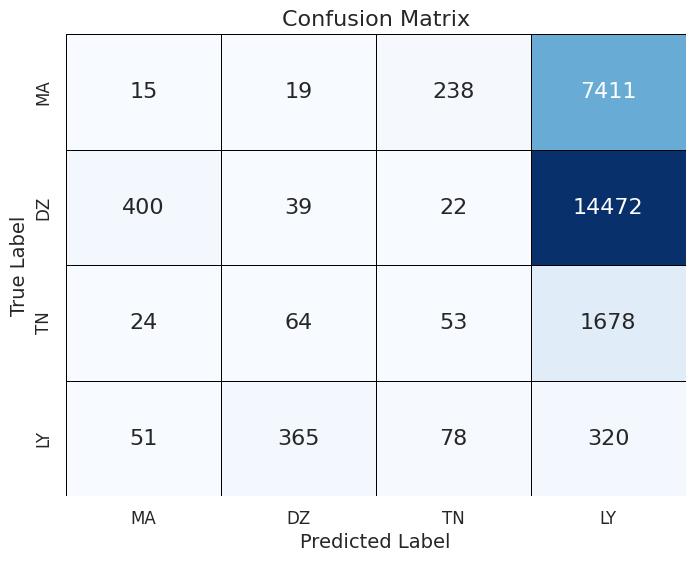

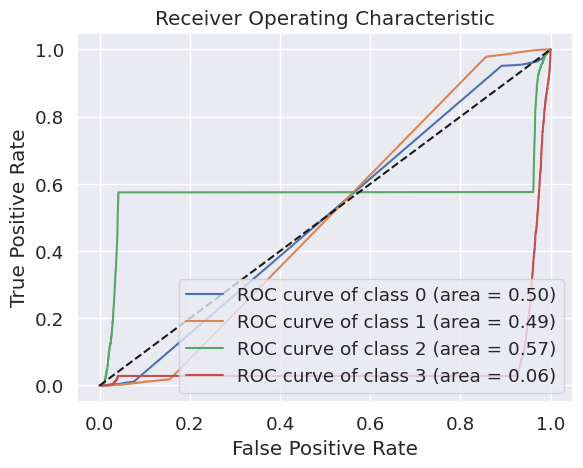

{0: 0.49747476611107955, 1: 0.4925301314204092, 2: 0.5705370142121491, 3: 0.05715137538341958}
{'test_loss': 6.935760498046875, 'test_macro_f1': 0.020652241702475784, 'test_macro_f1_pos_neg': 0.02651108333186612, 'test_macro_precision': 0.06491100660578777, 'test_macro_recall': 0.10670532732950685, 'test_accuracy': 0.016911560853895204, 'test_roc_auc': {0: 0.49747476611107955, 1: 0.4925301314204092, 2: 0.5705370142121491, 3: 0.05715137538341958}, 'test_roc_curve': ({0: array([0.00000000e+00, 1.13856313e-04, 1.70784470e-04, ...,
       9.99886144e-01, 9.99886144e-01, 1.00000000e+00]), 1: array([0.00000000e+00, 9.69367972e-05, 7.75494378e-04, ...,
       9.99806126e-01, 1.00000000e+00, 1.00000000e+00]), 2: array([0.00000000e+00, 4.26803244e-05, 2.56081946e-04, ...,
       9.99445156e-01, 9.99530516e-01, 1.00000000e+00]), 3: array([0.00000000e+00, 8.18498056e-05, 1.63699611e-04, ...,
       9.99959075e-01, 9.99959075e-01, 1.00000000e+00])}, {0: array([0.        , 0.        , 0.        , .

In [71]:
# Evaluate test set
test_results = trainer.predict(test_dataset)

# Print test set results
print(test_results.metrics)